In [1]:
import os
import sys
import time
import pickle
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt

from ast import literal_eval
from scipy.integrate import odeint

from sklearn.model_selection import train_test_split

from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from metrics import get_metrics_df
from narmax.utils import narmax_state_space, display_nx_model
from networks.utils import barabasi_sol, barabasi_diff, barabasi_fitt

In [2]:
# Custom function for identification
custom_library = ps.CustomLibrary(library_functions=[lambda x, y : x / y], 
                                  function_names=[lambda x, y : x + '/' + y])

In [3]:
# Get Wide Averaged Models low fitness
file = '100_BADFitness_[0.25, 0.75]_(10000,2).dat'
folder_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
file_path = os.path.join(folder_path, file)

with open(file_path, "rb") as input_file:
    data = pickle.load(input_file)

# Get Model characteristics from filename
net_args = file.split('_')
gen_args = literal_eval(net_args[-1].replace('.dat', ''))

# Load Simulated Data
m = gen_args[1]
n = gen_args[0]
t = np.arange(1, n - m + 1)

avg_degrees_hist = data['avg_degree']
fv_low = np.array(list(data['fv'].values()))
k_low_ant_sol = barabasi_fitt(m, fv_low, avg_degrees_hist, 0)

k_low = avg_degrees_hist[:,0]

# Get Wide Averaged Models high fitness
file = '100_BADFitness_[0.75, 0.25]_(10000,2).dat'
folder_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
file_path = os.path.join(folder_path, file)

with open(file_path, "rb") as input_file:
    data = pickle.load(input_file)

avg_degrees_hist = data['avg_degree']
fv_high = np.array(list(data['fv'].values()))
k_high_ant_sol = barabasi_fitt(m, fv_high, avg_degrees_hist, 0)

k_high = avg_degrees_hist[:,0]

# Split Data into Train-Test
k_low_train, k_low_test, t_train, t_test = train_test_split(k_low, t, test_size=0.6, shuffle=False)
k_high_train, k_high_test, t_train, t_test = train_test_split(k_high, t, test_size=0.6, shuffle=False)

# Conformal Mapping of Time, to adjust into Polynomial Basis
x_train = 1/t_train
x_test = 1/t_test

In [4]:
# Define lower SINDy Model
sindy_low_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=custom_library+ps.PolynomialLibrary(degree=5),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't']
)

# Fit model and get time taken
tic = time.time()
sindy_low_model.fit(k_low_train, u=t_train, quiet=True)
toc = time.time()
sindy_low_time = toc - tic

# Print resulting model
print('Lower fitness: ', end='')
sindy_low_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_low_model.simulate(k_low_test[0], u=t_test, t=t_test)
sindy_sim_low = np.vstack((k_low_test[0], sindy_sim))


# Define lower SINDy Model
sindy_high_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=custom_library+ps.PolynomialLibrary(degree=5),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't']
)

# Fit model and get time taken
tic = time.time()
sindy_high_model.fit(k_high_train, u=t_train, quiet=True)
toc = time.time()
sindy_high_time = toc - tic

# Print resulting model
print('Upper fitness: ', end='')
sindy_high_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_high_model.simulate(k_high_test[0], u=t_test, t=t_test)
sindy_sim_high = np.vstack((k_high_test[0], sindy_sim))

Lower fitness: k' = 0.282 k/t
Upper fitness: k' = 0.592 k/t


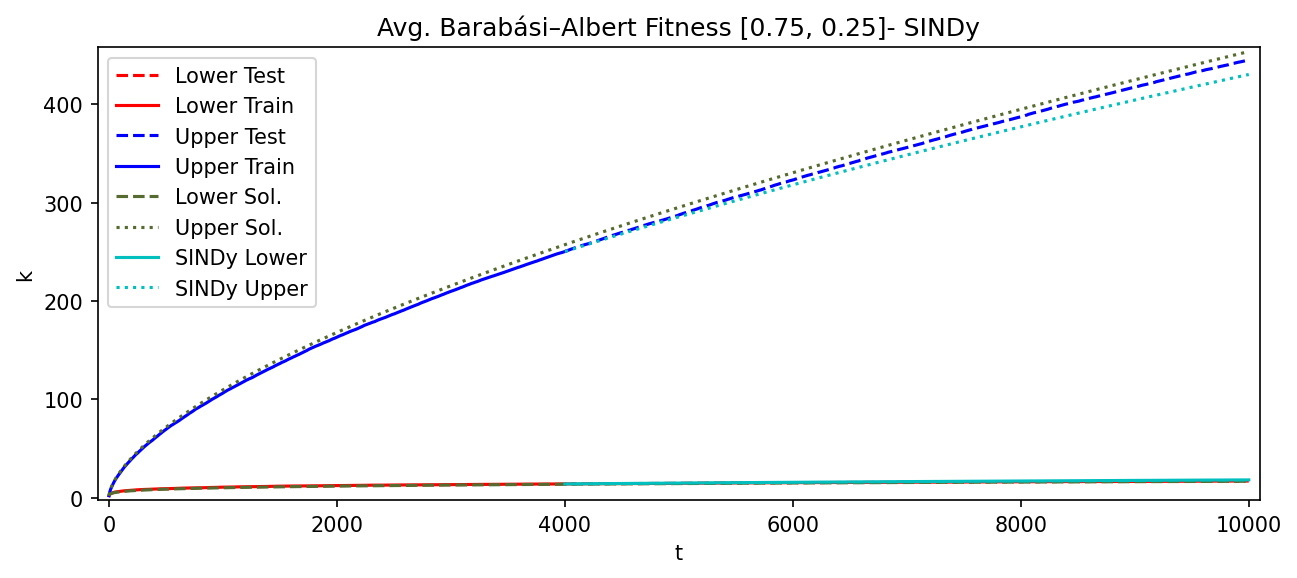

In [5]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Avg. Barabási–Albert Fitness [0.75, 0.25]- SINDy')
plt.plot(t_test, k_low_test, "r--", label="Lower Test")
plt.plot(t_train, k_low_train, "r", label="Lower Train")

plt.plot(t_test, k_high_test, "b--", label="Upper Test")
plt.plot(t_train, k_high_train, "b", label="Upper Train")

plt.plot(t, k_low_ant_sol, color='darkolivegreen', linestyle='dashed', label="Lower Sol.")
plt.plot(t, k_high_ant_sol, color='darkolivegreen', linestyle='dotted', label="Upper Sol.")

plt.plot(t_test, sindy_sim_low, "c", label="SINDy Lower")
plt.plot(t_test, sindy_sim_high, "c", linestyle='dotted', label="SINDy Upper")

plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [6]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_low_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

# Train model for the state X and get time
tic = time.time()
nx_low_model.fit(X=x_train.reshape(-1, 1), y=k_low_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_low_model.theta.flatten(), (0, nx_low_model.basis_function.__sizeof__() - len(nx_low_model.theta)))
params = results(nx_low_model.final_model, nx_low_model.theta, nx_low_model.err, nx_low_model.n_terms, dtype='sci')
print('Lower fitness: ', end='')
display_nx_model(params, nx_low_model.theta, 'k', ['1/t'], 1)
# Simulate model for the state X
sim_y = nx_low_model.predict(X=x_test.reshape(-1, 1), y=k_low_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_low_model = np.array([coeffs_y])
narmax_sim_low = sim_y


# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_high_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

# Train model for the state X and get time
tic = time.time()
nx_high_model.fit(X=x_train.reshape(-1, 1), y=k_high_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_high_model.theta.flatten(), (0, nx_high_model.basis_function.__sizeof__() - len(nx_high_model.theta)))
params = results(nx_high_model.final_model, nx_high_model.theta, nx_high_model.err, nx_high_model.n_terms, dtype='sci')
print('Upper fitness: ', end='')
display_nx_model(params, nx_high_model.theta, 'k', ['1/t'], 1)
# Simulate model for the state X
sim_y = nx_high_model.predict(X=x_test.reshape(-1, 1), y=k_high_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_high_model = np.array([coeffs_y])
narmax_sim_high = sim_y

Lower fitness: k[k+1] = 1.000E+00 k[k] + 2.306E-01 1/t[k]k[k]
Upper fitness: k[k+1] = 1.000E+00 k[k] + 6.150E-01 1/t[k]k[k] - 3.917E-01 1/t[k]


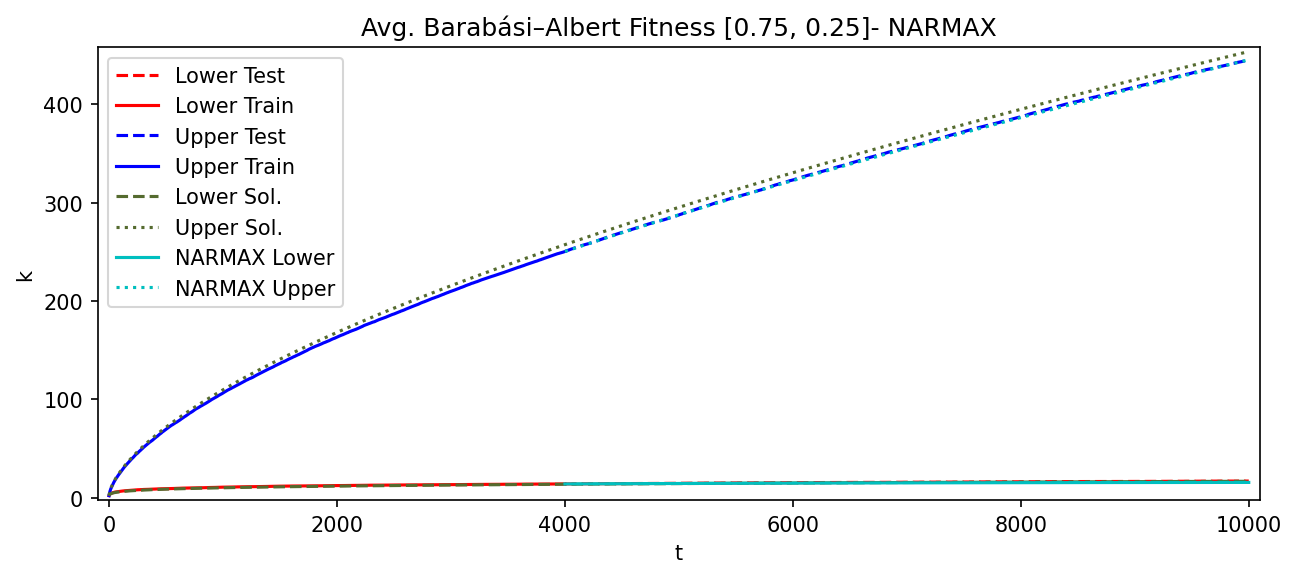

In [7]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Avg. Barabási–Albert Fitness [0.75, 0.25]- NARMAX')
plt.plot(t_test, k_low_test, "r--", label="Lower Test")
plt.plot(t_train, k_low_train, "r", label="Lower Train")

plt.plot(t_test, k_high_test, "b--", label="Upper Test")
plt.plot(t_train, k_high_train, "b", label="Upper Train")

plt.plot(t, k_low_ant_sol, color='darkolivegreen', linestyle='dashed', label="Lower Sol.")
plt.plot(t, k_high_ant_sol, color='darkolivegreen', linestyle='dotted', label="Upper Sol.")

plt.plot(t_test, narmax_sim_low, "c", label="NARMAX Lower")
plt.plot(t_test, narmax_sim_high, "c", linestyle='dotted', label="NARMAX Upper")

plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [8]:
# Lower Metrics DataFrame
get_metrics_df(k_low_test, [1], sindy_low_model, narmax_low_model, sindy_sim_low, narmax_sim_low, sindy_low_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[1.0],[0.0],1.0,-0.600053,0.473732,91.764321,0.320310,0.052650
NARMAX,[2.0],[1.0],2.0,0.678008,0.623370,111.468235,0.105618,0.017218


In [9]:
# Upper Metrics DataFrame
get_metrics_df(k_high_test, [1], sindy_high_model, narmax_high_model, sindy_sim_high, narmax_sim_high, sindy_high_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[1.0],[0.0],1.0,7.753931,81.240774,113.811562,0.974299,0.009992
NARMAX,[3.0],[2.0],3.0,0.728296,0.755411,109.792658,0.999761,0.017218


In [10]:
# Get Wide Averaged Models low fitness
file = '1_BADFitness_[0.25, 0.75]_(10000,2).dat'
folder_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
file_path = os.path.join(folder_path, file)

with open(file_path, "rb") as input_file:
    data = pickle.load(input_file)

# Get Model characteristics from filename
net_args = file.split('_')
gen_args = literal_eval(net_args[-1].replace('.dat', ''))

# Load Simulated Data
m = gen_args[1]
n = gen_args[0]
t = np.arange(1, n - m + 1)

avg_degrees_hist = data['avg_degree']
fv_low = np.array(list(data['fv'].values()))
k_low_ant_sol = barabasi_fitt(m, fv_low, avg_degrees_hist, 0)

k_low = avg_degrees_hist[:,0]

# Get Wide Averaged Models high fitness
file = '1_BADFitness_[0.75, 0.25]_(10000,2).dat'
folder_path = os.path.join(os.path.abspath(''), '..', 'Data', 'Generated', 'Barabasi')
file_path = os.path.join(folder_path, file)

with open(file_path, "rb") as input_file:
    data = pickle.load(input_file)

avg_degrees_hist = data['avg_degree']
fv_high = np.array(list(data['fv'].values()))
k_high_ant_sol = barabasi_fitt(m, fv_high, avg_degrees_hist, 0)

k_high = avg_degrees_hist[:,0]

# Split Data into Train-Test
k_low_train, k_low_test, t_train, t_test = train_test_split(k_low, t, test_size=0.6, shuffle=False)
k_high_train, k_high_test, t_train, t_test = train_test_split(k_high, t, test_size=0.6, shuffle=False)

# Conformal Mapping of Time, to adjust into Polynomial Basis
x_train = 1/t_train
x_test = 1/t_test

In [11]:
# Define lower SINDy Model
sindy_low_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=custom_library+ps.PolynomialLibrary(degree=5),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't']
)

# Fit model and get time taken
tic = time.time()
sindy_low_model.fit(k_low_train, u=t_train, quiet=True)
toc = time.time()
sindy_low_time = toc - tic

# Print resulting model
print('Lower fitness: ', end='')
sindy_low_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_low_model.simulate(k_low_test[0], u=t_test, t=t_test)
sindy_sim_low = np.vstack((k_low_test[0], sindy_sim))


# Define lower SINDy Model
sindy_high_model = ps.SINDy(
    differentiation_method=ps.FiniteDifference(),
    feature_library=custom_library+ps.PolynomialLibrary(degree=5),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't']
)

# Fit model and get time taken
tic = time.time()
sindy_high_model.fit(k_high_train, u=t_train, quiet=True)
toc = time.time()
sindy_high_time = toc - tic

# Print resulting model
print('Upper fitness: ', end='')
sindy_high_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_high_model.simulate(k_high_test[0], u=t_test, t=t_test)
sindy_sim_high = np.vstack((k_high_test[0], sindy_sim))

Lower fitness: k' = 0.480 k/t
Upper fitness: k' = 0.592 k/t


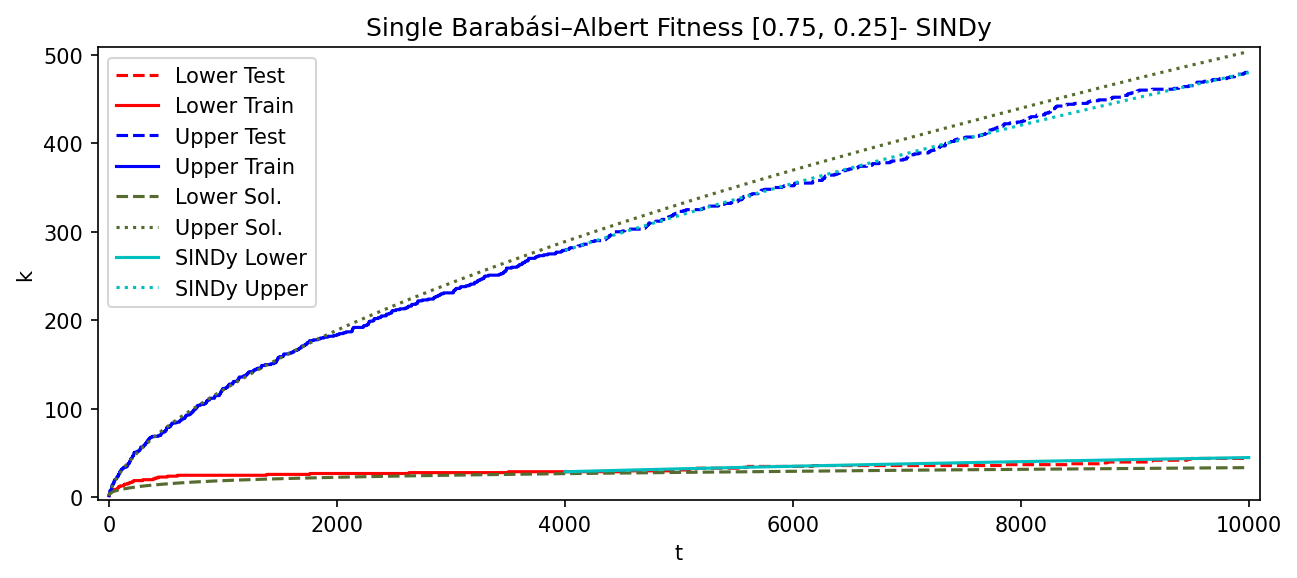

In [12]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Single Barabási–Albert Fitness [0.75, 0.25]- SINDy')
plt.plot(t_test, k_low_test, "r--", label="Lower Test")
plt.plot(t_train, k_low_train, "r", label="Lower Train")

plt.plot(t_test, k_high_test, "b--", label="Upper Test")
plt.plot(t_train, k_high_train, "b", label="Upper Train")

plt.plot(t, k_low_ant_sol, color='darkolivegreen', linestyle='dashed', label="Lower Sol.")
plt.plot(t, k_high_ant_sol, color='darkolivegreen', linestyle='dotted', label="Upper Sol.")

plt.plot(t_test, sindy_sim_low, "c", label="SINDy Lower")
plt.plot(t_test, sindy_sim_high, "c", linestyle='dotted', label="SINDy Upper")

plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [13]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_low_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

# Train model for the state X and get time
tic = time.time()
nx_low_model.fit(X=x_train.reshape(-1, 1), y=k_low_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_low_model.theta.flatten(), (0, nx_low_model.basis_function.__sizeof__() - len(nx_low_model.theta)))
params = results(nx_low_model.final_model, nx_low_model.theta, nx_low_model.err, nx_low_model.n_terms, dtype='sci')
print('Lower fitness: ', end='')
display_nx_model(params, nx_low_model.theta, 'k', ['1/t'], 1)
# Simulate model for the state X
sim_y = nx_low_model.predict(X=x_test.reshape(-1, 1), y=k_low_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_low_model = np.array([coeffs_y])
narmax_sim_low = sim_y


# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_high_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=2)
)

# Train model for the state X and get time
tic = time.time()
nx_high_model.fit(X=x_train.reshape(-1, 1), y=k_high_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_high_model.theta.flatten(), (0, nx_high_model.basis_function.__sizeof__() - len(nx_high_model.theta)))
params = results(nx_high_model.final_model, nx_high_model.theta, nx_high_model.err, nx_high_model.n_terms, dtype='sci')
print('Upper fitness: ', end='')
display_nx_model(params, nx_high_model.theta, 'k', ['1/t'], 1)
# Simulate model for the state X
sim_y = nx_high_model.predict(X=x_test.reshape(-1, 1), y=k_high_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_high_model = np.array([coeffs_y])
narmax_sim_high = sim_y

Lower fitness: k[k+1] = 9.777E-01 k[k] - 1.176E+00 1/t[k]k[k] + 4.638E+00 1/t[k] + 4.019E-01 1 + 2.979E-04 k[k]^2 - 1.752E+00 1/t[k]^2
Upper fitness: k[k+1] = 1.000E+00 k[k] + 5.772E-01 1/t[k]k[k]


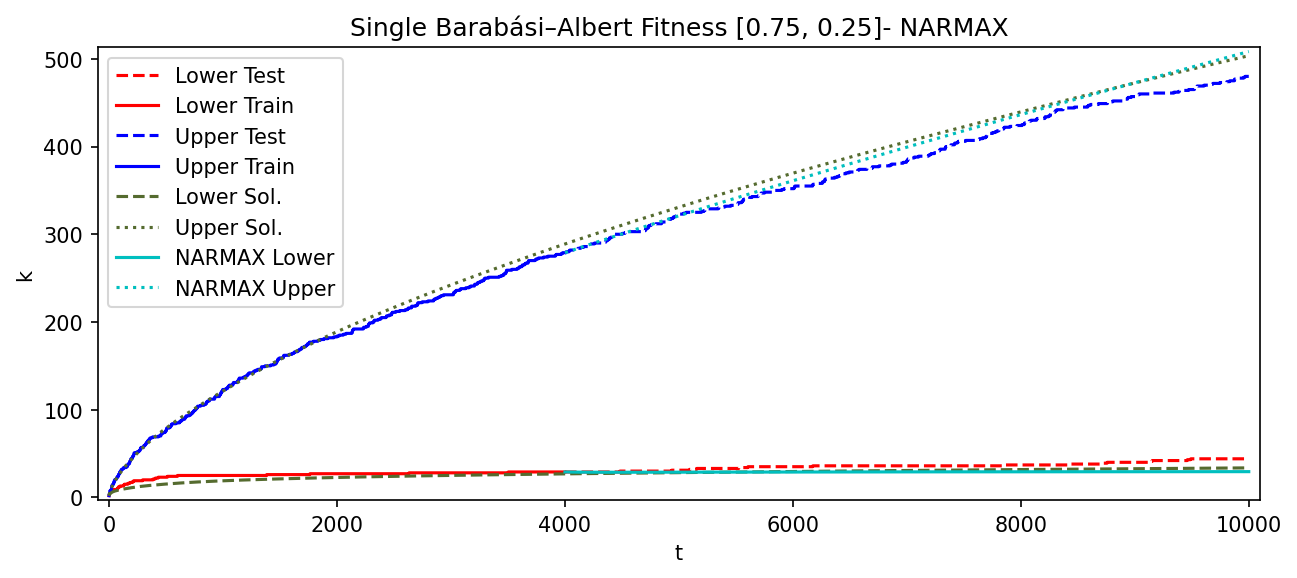

In [15]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Single Barabási–Albert Fitness [0.75, 0.25]- NARMAX')
plt.plot(t_test, k_low_test, "r--", label="Lower Test")
plt.plot(t_train, k_low_train, "r", label="Lower Train")

plt.plot(t_test, k_high_test, "b--", label="Upper Test")
plt.plot(t_train, k_high_train, "b", label="Upper Train")

plt.plot(t, k_low_ant_sol, color='darkolivegreen', linestyle='dashed', label="Lower Sol.")
plt.plot(t, k_high_ant_sol, color='darkolivegreen', linestyle='dotted', label="Upper Sol.")

plt.plot(t_test, narmax_sim_low, "c", label="NARMAX Lower")
plt.plot(t_test, narmax_sim_high, "c", linestyle='dotted', label="NARMAX Upper")

plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [16]:
# Lower Metrics DataFrame
get_metrics_df(k_low_test, [1], sindy_low_model, narmax_low_model, sindy_sim_low, narmax_sim_low, sindy_low_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[1.0],[0.0],1.0,-1.610254,4.509362,101.855533,0.737443,0.006738
NARMAX,[6.0],[5.0],6.0,6.955643,63.936691,90.147226,-2.722710,0.025194


In [17]:
# Upper Metrics DataFrame
get_metrics_df(k_high_test, [1], sindy_high_model, narmax_high_model, sindy_sim_high, narmax_sim_high, sindy_high_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[1.0],[0.0],1.0,1.121041,15.890953,111.061657,0.995466,0.005044
NARMAX,[2.0],[1.0],2.0,-10.867905,175.930304,103.542842,0.949798,0.025194


In [21]:
# Define lower SINDy Model
sindy_low_model = ps.SINDy(
    feature_library=custom_library+ps.PolynomialLibrary(degree=5),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't'],
    discrete_time=True
)

# Fit model and get time taken
tic = time.time()
sindy_low_model.fit(k_low_train, u=t_train, quiet=True)
toc = time.time()
sindy_low_time = toc - tic

# Print resulting model
print('Lower fitness: ', end='')
sindy_low_model.print()

# Simulate SINDy on the test data
sindy_sim_low = sindy_low_model.simulate(k_low_test[0], u=t_test, t=len(t_test))


# Define lower SINDy Model
sindy_high_model = ps.SINDy(
    feature_library=custom_library+ps.PolynomialLibrary(degree=5),
    optimizer=ps.STLSQ(threshold=1e-2),
    feature_names=['k', 't'],
    discrete_time=True
)

# Fit model and get time taken
tic = time.time()
sindy_high_model.fit(k_high_train, u=t_train, quiet=True)
toc = time.time()
sindy_high_time = toc - tic

# Print resulting model
print('Upper fitness: ', end='')
sindy_high_model.print()

# Simulate SINDy on the test data
sindy_sim_high = sindy_high_model.simulate(k_high_test[0], u=t_test, t=len(t_test))

Lower fitness: k[k+1] = 0.310 k[k]/t[k] + 0.027 1 + 0.999 k[k]
Upper fitness: k[k+1] = 0.460 k[k]/t[k] + 0.039 1 + 1.000 k[k]


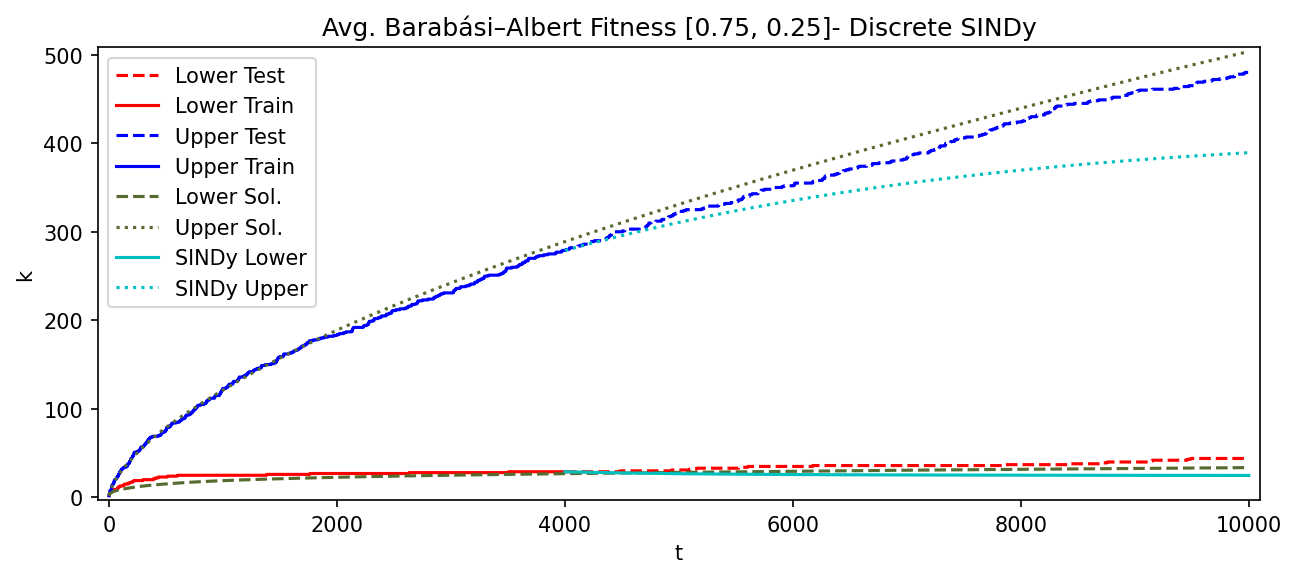

In [22]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Avg. Barabási–Albert Fitness [0.75, 0.25]- Discrete SINDy')
plt.plot(t_test, k_low_test, "r--", label="Lower Test")
plt.plot(t_train, k_low_train, "r", label="Lower Train")

plt.plot(t_test, k_high_test, "b--", label="Upper Test")
plt.plot(t_train, k_high_train, "b", label="Upper Train")

plt.plot(t, k_low_ant_sol, color='darkolivegreen', linestyle='dashed', label="Lower Sol.")
plt.plot(t, k_high_ant_sol, color='darkolivegreen', linestyle='dotted', label="Upper Sol.")

plt.plot(t_test, sindy_sim_low, "c", label="SINDy Lower")
plt.plot(t_test, sindy_sim_high, "c", linestyle='dotted', label="SINDy Upper")

plt.margins(0.01, tight=True)
plt.xlabel("t")
plt.ylabel("k")
plt.legend()
print(end='')

In [23]:
# Lower Metrics DataFrame
get_metrics_df(k_low_test, [1], sindy_low_model, narmax_low_model, sindy_sim_low, narmax_sim_low, sindy_low_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[3.0],[2.0],3.0,10.243752,130.628832,83.492570,-6.605857,0.012145
NARMAX,[6.0],[5.0],6.0,6.955643,63.936691,90.147226,-2.722710,0.025194


In [24]:
# Upper Metrics DataFrame
get_metrics_df(k_high_test, [1], sindy_high_model, narmax_high_model, sindy_sim_high, narmax_sim_high, sindy_high_time, narmax_time)

,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,R2 Score,Time
SINDy,[3.0],[2.0],3.0,38.682459,2320.479155,120.232440,0.337850,0.007705
NARMAX,[2.0],[1.0],2.0,-10.867905,175.930304,103.542842,0.949798,0.025194
